### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [24]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import io
import copy
from tqdm.notebook import tqdm  # tqdm.notebookをインポート
from IPython.display import display, HTML



sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 100 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1500 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
TOTAL_TIME = 200 # シミュレーション時間

# 研究用のパラメータ
TTC = 1.5 #車間時間を暫定的に定義
COMMUNICATION_SPEED = 0.2
DENSITY = 2.2 # 台数密度を車間時間として定義
NOISE_FORECAST_TIME = 5 # 何秒後の擾乱を前もって知らせるか. 
NOISE_PERIOD = 5
NOISE_FREQUENCY = 10

def generate_arrival_times(car_num, d, TOTAL_TIME):
    sequence = [random.uniform(0, 3)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + d + random.uniform(0, 2) + 0.2 # これは +0.2しておかないと入り口の時点で弾かれる場合がある
        sequence.append(next_value)
        if next_value > TOTAL_TIME:
            break
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, DENSITY, TOTAL_TIME)
# 20240905時点, 下のarrival_timesはnoise_forecast_timeが5秒の時に減速しすぎてバグるものの検証用. 
# arrival_times = [0.9958288129982859, 5.287233129036741, 8.59464779137927, 12.41331846102123, 15.35178948508543, 18.089027551552434, 21.686473194033372, 25.529885585952535, 28.738588920141332, 31.378984378605875, 34.15069324094699, 38.65461736127613, 42.198918455182785, 44.82187773076833, 47.74355633196187, 51.248831946417724, 55.803139174787816, 59.229418797468156, 62.999513051941044, 66.78782028356221, 71.02697798225786, 74.26037069872682, 78.09280366333712, 81.04959819369992, 83.92590031213548, 87.6810002060757, 91.15995049508086, 95.57577501493115, 99.71979174670052, 103.61323987259884, 107.34415195924623, 110.17723676263368, 114.31655631511981, 118.61473746052114, 122.22498233706457, 126.35813425375207, 130.16457913202967, 134.61603085666923, 138.30915595700654, 141.34660409333318, 144.99197966479127, 148.8968522850624, 152.6395259702966, 156.64599365656315, 160.03272764553176, 163.6837266270248, 166.38981340089035, 169.01848494283718, 171.76510882618564, 175.46834644834394, 178.61525117429943, 181.97163487521098, 185.57156983968724, 188.65696185567373, 193.11033685139793, 196.51362290447034, 200.48319209878795, 201.7]

# Fundamental DiagramのFlow上で変な点が打たれているものの検証用. 
# arrival_times = [1.0310824790512072, 6.086139257065011, 9.419851936796247, 13.883497127770163, 17.82097845333444, 22.75136775488384, 25.95418037327338, 30.75631086422296, 34.43794127057427, 38.60584224589726, 43.302756180283566, 47.581475447479114, 52.434194074764775, 56.13116166776117, 60.33909775965751, 64.81052409393061, 68.5736237032782, 72.49102959390359, 76.28853619717584, 80.74573132049731, 85.36129209927932, 88.85473538914252, 92.98307794600596, 96.98564213649281, 101.98586861163321, 105.41754465254016, 110.19310659439162, 113.6515315266129, 117.16492556121987, 121.9660937618126, 127.07263081023966, 130.52522392687868, 135.6192097606384, 139.7050982259903, 144.1693081392143, 147.4976445140848, 151.43624162652168, 154.69758328418752, 158.25330798158816, 162.4712938764683, 166.24973333171067, 170.85374393228167, 175.37166355898725, 179.4599705351612, 184.21946612063164, 189.38661431578544, 194.18836963857947, 197.8482285899103, 202.11081922622253, 201.7]
# arrival_times = [1.940294016141174, 4.998027852780362, 8.795099574369049, 11.923876140566326, 15.34570308448153, 18.021976093808508, 22.062716118345996, 25.28921112535561, 27.791468647853364, 31.797448522334204, 34.22581569155911, 38.2120242527798, 41.87775630401881, 45.002406035734104, 48.97484603105231, 51.98932381080593, 55.035054521260356, 59.087389289368254, 62.659902194832, 65.62995521398902, 69.79353892634347, 73.50929120421806, 76.36095039902847, 80.65717090551087, 83.80561540382172, 86.3369459601201, 89.99755466478344, 92.78084596548614, 95.43503528273247, 98.25500984561947, 100.85199665186707, 104.32497291111994, 108.12545467896842, 112.30307250539646, 115.0051398794221, 118.32260960930896, 120.82380678921517, 124.76615261293107, 128.97935561675544, 132.49545185532978, 135.66987677157553, 138.390381540357, 142.63831736279377, 146.60875942134385, 149.30818036385415, 151.99412157325787, 154.67227666357456, 158.62483722512346, 161.78819504011813, 164.50279330626057, 168.1570372596157, 171.12620128224938, 174.66295668863305, 177.986336729101, 180.49396098177166, 183.8545741681378, 187.66429400556078, 191.72768110635585, 195.1931040450994, 198.30574677106793, 201.00192258074253]
car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}

def create_noise(current_time):
    if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
        return {"x": [520, 550], "t": [current_time + NOISE_FORECAST_TIME, current_time + NOISE_FORECAST_TIME + NOISE_PERIOD]}
    # この場合はノイズを発生させない.
    return None

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

In [25]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

In [26]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

# 各車がETAを決める部分
register_initial_eta(CARS)

In [27]:
# ここからDFRのシミュレーション
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table, create_noise=create_noise, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=DENSITY)
simulation.conduct_simulation(should_plot=True)

Simulation Progress DFR, density=2.2:   0%|          | 0/2000 [00:00<?, ?it/s]

直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []

t=10.0, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=noise created
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []
t=10.0, car_id:0, xcor:162.0, speed:20
t=10.0, car_id:1, xcor:102.0, speed:20
t=10.0, car_id:2, xcor:26.0, speed:20

t=10.100000000000001, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.200000000000001, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.3, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.4, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.5, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.600000000000001, next_car=3, current_noise= [{'x': [520, 550], 't': [15.0, 20.0]}], event_flg=None

t=10.700000000000001, next_car=3, current_n

In [31]:
print(arrival_times)

[1.940294016141174, 4.998027852780362, 8.795099574369049, 11.923876140566326, 15.34570308448153, 18.021976093808508, 22.062716118345996, 25.28921112535561, 27.791468647853364, 31.797448522334204, 34.22581569155911, 38.2120242527798, 41.87775630401881, 45.002406035734104, 48.97484603105231, 51.98932381080593, 55.035054521260356, 59.087389289368254, 62.659902194832, 65.62995521398902, 69.79353892634347, 73.50929120421806, 76.36095039902847, 80.65717090551087, 83.80561540382172, 86.3369459601201, 89.99755466478344, 92.78084596548614, 95.43503528273247, 98.25500984561947, 100.85199665186707, 104.32497291111994, 108.12545467896842, 112.30307250539646, 115.0051398794221, 118.32260960930896, 120.82380678921517, 124.76615261293107, 128.97935561675544, 132.49545185532978, 135.66987677157553, 138.390381540357, 142.63831736279377, 146.60875942134385, 149.30818036385415, 151.99412157325787, 154.67227666357456, 158.62483722512346, 161.78819504011813, 164.50279330626057, 168.1570372596157, 171.12620

     local_density     v_mean         flow
0              1.0  24.043939    24.043939
1              3.0  25.953333    77.860000
2              4.0  23.507591    94.030366
3              5.0  20.010945   100.054726
4              6.0  19.324939   115.949633
..             ...        ...          ...
135          140.0   9.200000  1288.000000
136          141.0   7.400000  1043.400000
137          143.0   8.300000  1186.900000
138          144.0   8.600000  1238.400000
139          145.0   8.150000  1181.750000

[140 rows x 3 columns]


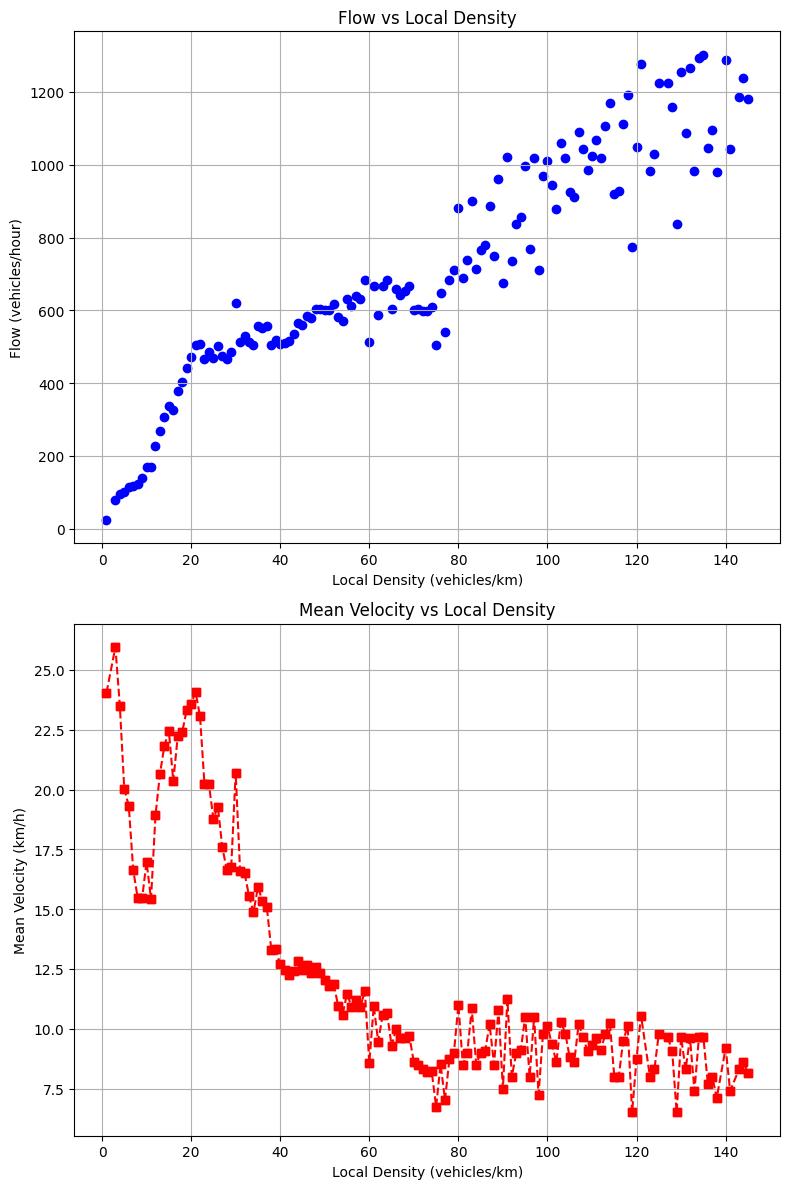

In [30]:
def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped
    
headway_list = simulation.headway_log
headway_df = pd.DataFrame(headway_list)
data = process_headway_data(headway_df)
print(data)
# 2つのグラフを縦に並べて描画
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# 1つ目のグラフ (flow vs local_density)
# ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
ax1.scatter(data['local_density'], data['flow'], marker='o', color='b')
ax1.set_title('Flow vs Local Density')
ax1.set_xlabel('Local Density (vehicles/km)')
ax1.set_ylabel('Flow (vehicles/hour)')
ax1.grid(True)

# 2つ目のグラフ (v_mean vs local_density)
ax2.plot(data['local_density'], data['v_mean'], marker='s', linestyle='--', color='r')
ax2.scatter(data['local_density'], data['v_mean'], marker='s', color='r')
ax2.set_title('Mean Velocity vs Local Density')
ax2.set_xlabel('Local Density (vehicles/km)')
ax2.set_ylabel('Mean Velocity (km/h)')
ax2.grid(True)

# レイアウトの調整と表示
plt.tight_layout()
plt.show()

In [17]:
DENSITY_LIST = [10, 4, 3, 2.4, 1.8]
NOISE_FORECAST_TIME_LIST = [5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2]
TOTAL_TIME=200
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict

def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped

all_headway_dfs = []    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)
with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [520, 550], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        headway_list = dfr_simulation.headway_log
                        headway_df = pd.DataFrame(headway_list)
                        headway_df = process_headway_data(headway_df)
                        # 追加カラムを追加する
                        headway_df['density'] = density
                        headway_df['noise_forecast_time'] = noise_forecast_time
                        headway_df['noise_period'] = noise_period
                        headway_df['communication_speed'] = communication_speed
                
                        # 結果をリストに追加
                        all_headway_dfs.append(headway_df)
                        
                
                    except:
                        sys.stdout = original_stdout
                        print(arrival_times)
                        
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    pbar.update(1)
                    
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
               

  0%|          | 0/5 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=3:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=2.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=1.8:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.9958288129982859, 5.287233129036741, 8.59464779137927, 12.41331846102123, 15.35178948508543, 18.089027551552434, 21.686473194033372, 25.529885585952535, 28.738588920141332, 31.378984378605875, 34.15069324094699, 38.65461736127613, 42.198918455182785, 44.82187773076833, 47.74355633196187, 51.248831946417724, 55.803139174787816, 59.229418797468156, 62.999513051941044, 66.78782028356221, 71.02697798225786, 74.26037069872682, 78.09280366333712, 81.04959819369992, 83.92590031213548, 87.6810002060757, 91.15995049508086, 95.57577501493115, 99.71979174670052, 103.61323987259884, 107.34415195924623, 110.17723676263368, 114.31655631511981, 118.61473746052114, 122.22498233706457, 126.35813425375207, 130.16457913202967, 134.61603085666923, 138.30915595700654, 141.34660409333318, 144.99197966479127, 148.8968522850624, 152.6395259702966, 156.64599365656315, 160.03272764553176, 163.6837266270248, 166.38981340089035, 169.01848494283718, 171.76510882618564, 175.46834644834394, 178.61525117429943, 18

In [27]:
print(arrival_time_log[2])

{'density': 3, 'arrival_times': [1.0310824790512072, 6.086139257065011, 9.419851936796247, 13.883497127770163, 17.82097845333444, 22.75136775488384, 25.95418037327338, 30.75631086422296, 34.43794127057427, 38.60584224589726, 43.302756180283566, 47.581475447479114, 52.434194074764775, 56.13116166776117, 60.33909775965751, 64.81052409393061, 68.5736237032782, 72.49102959390359, 76.28853619717584, 80.74573132049731, 85.36129209927932, 88.85473538914252, 92.98307794600596, 96.98564213649281, 101.98586861163321, 105.41754465254016, 110.19310659439162, 113.6515315266129, 117.16492556121987, 121.9660937618126, 127.07263081023966, 130.52522392687868, 135.6192097606384, 139.7050982259903, 144.1693081392143, 147.4976445140848, 151.43624162652168, 154.69758328418752, 158.25330798158816, 162.4712938764683, 166.24973333171067, 170.85374393228167, 175.37166355898725, 179.4599705351612, 184.21946612063164, 189.38661431578544, 194.18836963857947, 197.8482285899103, 202.11081922622253, 201.7]}


138


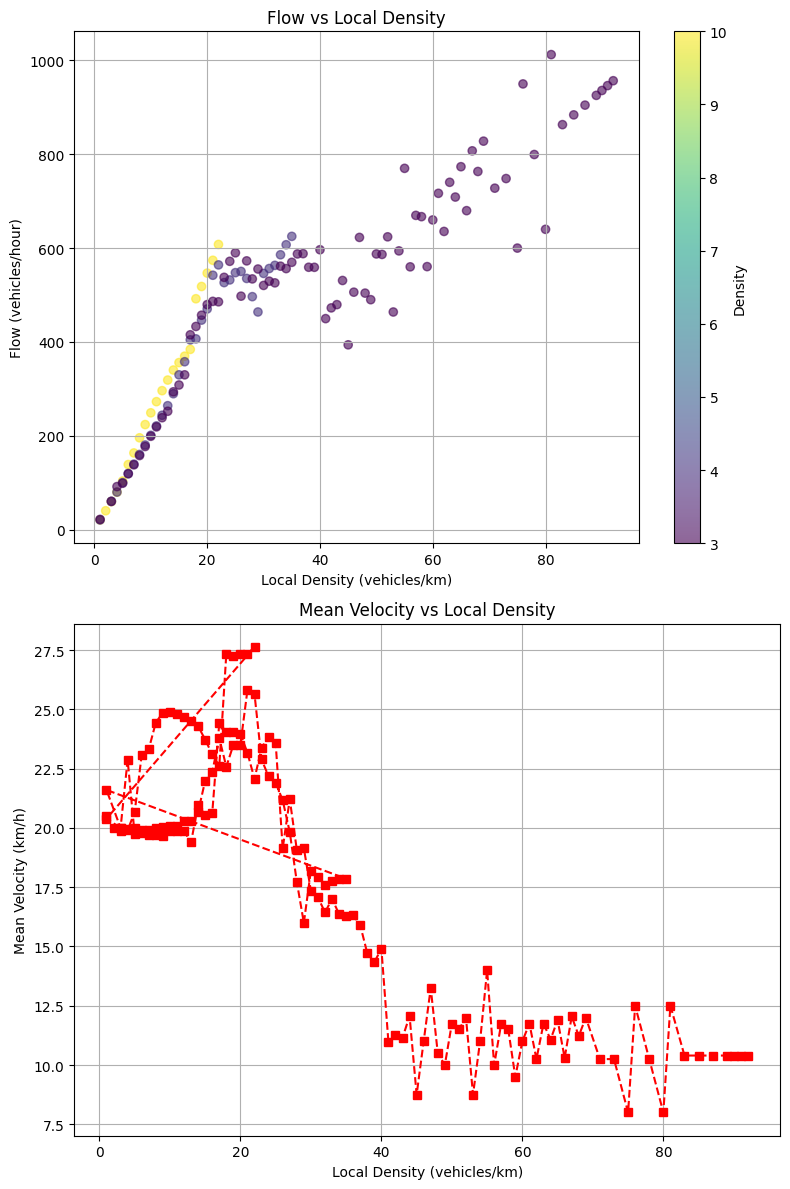

In [23]:
# 全てのheadway_dfを結合
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
# final_headway_dfを出力
print(len(final_headway_df))
final_headway_df.to_csv("density.csv")

def plot_fd(df):
    # local_densityが0以上のデータを抽出
    data = df[df['local_density'] >= 0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    scatter = ax1.scatter(data['local_density'], data['flow'], c=data['density'], cmap='viridis', marker='o', alpha=0.6)
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/hour)')
    ax1.grid(True)
    
    # カラーバー（densityに基づいて色を変える）
    cbar = fig.colorbar(scatter, ax=ax1)
    cbar.set_label('Density')

    
    # 2つ目のグラフ (v_mean vs local_density)
    ax2.plot(data['local_density'], data['v_mean'], marker='s', linestyle='--', color='r')
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (km/h)')
    ax2.grid(True)
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

plot_fd(final_headway_df)

### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [16]:
vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/800 [00:00<?, ?it/s]

t=2.6, event_flg=arrival, noise=[]
t=4.800000000000001, event_flg=arrival, noise=[]
t=8.700000000000001, event_flg=arrival, noise=[]
t=10.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=12.100000000000001, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=16.0, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=19.400000000000002, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=22.200000000000003, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=25.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=29.0, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=31.700000000000003, event_flg=arrival, noise=[]
t=35.2, event_flg=arrival, noise=[]
t=38.400000000000006, event_flg=arrival, noise=[]
t=40.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [55.0, 60.0]}]
t=41.5, event_flg=arrival, noise=[{'x': [420, 450], 't': [55.0, 60.0]}]
t=43.800000000000004, event_f

In [4]:
def plot_v_mean_log(path, v_mean_dfr, v_mean_vfr):
    v_mean_log = v_mean_dfr
    # event_flgが"noise"のデータポイントを抽出する
    noise_time = [entry["time"]
                  for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_v_mean = [entry["v_mean"]
                    for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_times = [entry["time"]
                   for entry in v_mean_vfr if entry.get("event_flg") == "noise"]

    # timeとv_meanをそれぞれリストに抽出する
    time = [entry["time"] for entry in v_mean_log]
    v_mean = [entry["v_mean"] for entry in v_mean_log]
    v_mean_vfr = [entry["v_mean"] for entry in v_mean_vfr]

    # グラフを描画する
    plt.figure(figsize=(10, 8))
    plt.plot(time, v_mean, label="DFR",)
    plt.plot(time, v_mean_vfr, label="VFR")

    # ノイズのデータポイントを赤丸でプロットする
    # plt.scatter(noise_time, noise_v_mean, color='red', label='Noise Event', zorder=5)

    # ノイズ発生タイミングに赤線
    for n in noise_times:
        plt.axvline(x=n, color='orange', linestyle='--', alpha=0.5,
                    linewidth=1)

    # グラフのタイトルとラベルを設定する
    plt.title('Mean Velocity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Velocity')

    plt.xlim(0, 85)
    plt.ylim(0, 32)
    plt.legend()

    # グリッドを表示する
    plt.grid(True)
    plt.savefig(path)

plot_v_mean_log("./images/dfr/v_mean_log_dfr_vs_vfr.png", simulation.v_mean_log, vfr_simulation.v_mean_log)

NameError: name 'simulation' is not defined

In [6]:
# Fundamental Diagram作るように一気にやるためのコードを書く. 
DENSITY_LIST = [20, 16, 12, 10, 8, 6, 4, 3 , 2.8, 2.4, 2, 1.8, 1.6, 1.5]
#DENSITY_LIST = [20,2]
NOISE_FORECAST_TIME_LIST = [5,10,15, 20]
#NOISE_FORECAST_TIME_LIST=[5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2, 0.5, 1, 1.5, 2]
# COMMU_SPEED_LIST=[0.2, 2]
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict


def collect_v_mean_by_density(data):
    cut_index = int(len(data) * 0.2)
    data = data[cut_index:]
    density_groups = defaultdict(list)
    for entry in data:
        density_groups[entry['density']].append(entry['v_mean'])
    
    # 各densityのv_meanの平均を計算
    density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}
    return density_mean_v_mean
    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)

with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [420, 450], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    result = {
                        "type": "dfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }

                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        dfr_log = dfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(dfr_log)
                        result["v_mean"] = v_mean_by_density
                
                    except:
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
    
                    results.append(result)
                    sys.stdout = original_stdout
                
                
                    # 続いてVFR
                    result = {
                        "type": "vfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }
                    try:
                        original_stdout = sys.stdout
                        sys.stdout = io.StringIO()
                        vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                        vfr_simulation.conduct_simulation(should_plot=False)
                        vfr_log = vfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(vfr_log)
                        result["v_mean"] = v_mean_by_density
                        
                    except: 
                        # sys.stderr.write(f"VFR simulation error for density {density}: {e}\n")
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
                        pass
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    results.append(result)
                    pbar.update(1)
print("DONE!")
result_df = pd.DataFrame(results)



  0%|          | 0/280 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

DONE!


In [5]:
filtered_df = result_df[(result_df['type'] == 'dfr') & (result_df['communication_speed'] == 2)]

# filtered_dfを表示して確認
print(filtered_df)

  type  density                                             v_mean  \
4  dfr       20  {0.002: 21.371121593291402, 0.0026666666666666...   
6  dfr        2                                               None   

   noise_forecast_time  noise_period  communication_speed  is_success  
4                    5             5                  2.0        True  
6                    5             5                  2.0       False  


In [7]:
result_df_copy = copy.deepcopy(result_df)
result_df_copy.drop(columns=['v_mean']).to_csv('result_df_without_v_mean.csv', index=False)

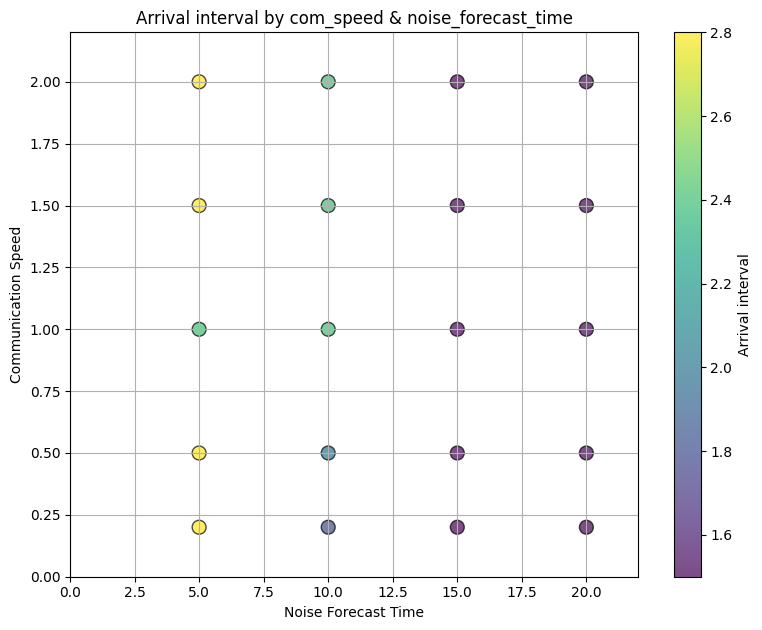

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result_from_csv = pd.read_csv("result_df_without_v_mean.csv")

def plot_forecast_vs_speed(_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = _df[(_df['is_success']) & (_df['type']=="dfr")]

    # 最小のdensityを取得するための辞書を作成
    min_density_by_forecast_and_speed = {}

    for _, row in successful_results.iterrows():
        key = (row['noise_forecast_time'], row['communication_speed'])
        if key not in min_density_by_forecast_and_speed:
            min_density_by_forecast_and_speed[key] = row['density']
        else:
            if row['density'] < min_density_by_forecast_and_speed[key]:
                min_density_by_forecast_and_speed[key] = row['density']

    # プロットの準備
    fig, ax = plt.subplots(figsize=(8, 6.4))

    # プロット用のリストを作成
    forecast_times = []
    comm_speeds = []
    min_densities = []

    for (forecast_time, comm_speed), min_density in min_density_by_forecast_and_speed.items():
        forecast_times.append(forecast_time)
        comm_speeds.append(comm_speed)
        min_densities.append(min_density)

    # 散布図をプロット
    scatter = ax.scatter(forecast_times, comm_speeds, c=min_densities, cmap='viridis', s=100, edgecolor='k', alpha=0.7)
    plt.colorbar(scatter, label='Arrival interval')

    ax.set_xlabel('Noise Forecast Time')
    ax.set_ylabel('Communication Speed')
    ax.set_title('Arrival interval by com_speed & noise_forecast_time')
    ax.grid(True)
    ax.set_ylim(0, 2.2)  # 縦軸の範囲を0から2.2までに設定
    ax.set_xlim(0, 22)  # 縦軸の範囲を0から2.2までに設定


    # グラフを表示
    plt.tight_layout()
    plt.show()

# 使用例
plot_forecast_vs_speed(result_from_csv)


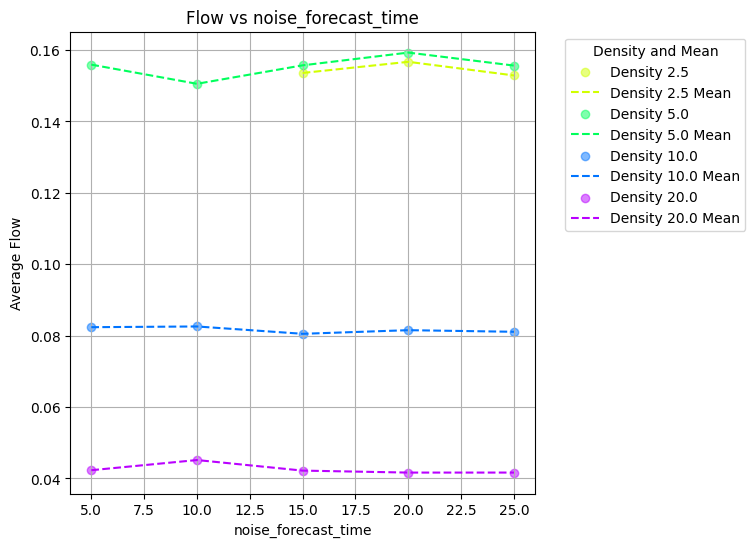

  type  density                                             v_mean  \
0  dfr     20.0  {0.002: 20.952614641995172, 0.0026666666666666...   
1  vfr     20.0  {0.0013333333333333333: 26.126724051992728, 0....   
2  dfr     10.0  {0.004: 21.10102730467694, 0.00466666666666666...   
3  vfr     10.0                                               None   
4  dfr      5.0  {0.006666666666666667: 19.879278846153845, 0.0...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  0.2        True   

       flow  
0  0.047677  
1  0.046179  
2  0.084386  
3       NaN  
4  0.149299  


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_result(result_df, axis):
    # 平均流量を計算して 'flow' 列に追加
    def calculate_mean_flow(v_mean_dict):
        if v_mean_dict:
            total_flow = sum(density * speed for density, speed in v_mean_dict.items())
            mean_flow = total_flow / len(v_mean_dict)
            return mean_flow
        else:
            return None

    # 'flow' 列を計算して追加
    result_df['flow'] = result_df['v_mean'].apply(calculate_mean_flow)

    # is_success が True のデータのみをフィルタリングし、DFRだけに絞る
    dfr_results = result_df[(result_df['is_success']) & (result_df['type'] == 'dfr')& (result_df['communication_speed'] == 2) ]
    # dfr_results = result_df[(result_df['type'] == 'dfr') & (result_df['noise_forecast_time'] == 15)]

    grouped = dfr_results.groupby('density')


    # プロット
    plt.figure(figsize=(6, 6))
    colors = sns.color_palette("hsv", len(grouped))  # 密度ごとの色を指定
    for (density, group), color in zip(grouped, colors):
        plt.scatter(group[axis], group['flow'], color=color, alpha=0.5, label=f'Density {density}')
        mean_flow = group.groupby(axis)['flow'].mean()
        plt.plot(mean_flow.index, mean_flow.values, color=color, linestyle='--', label=f'Density {density} Mean')

    
    plt.xlabel(axis)
    plt.ylabel('Average Flow')
    plt.title(f'Flow vs {axis}')
    plt.grid(True)
    plt.legend(title="Density and Mean", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    return result_df

# 使い方の例:
# analyze_result(result_df, 'density')
df = analyze_result(result_df, 'noise_forecast_time')
print(df.head())


In [28]:
print(df.head)

  type  density                                             v_mean  \
0  dfr       20  {0.002: 21.41955223880597, 0.00266666666666666...   
1  vfr       20  {0.0013333333333333333: 28.910429369581912, 0....   
2  dfr       18  {0.0026666666666666666: 20.642469376391983, 0....   
3  vfr       18  {0.002: 25.540685351784756, 0.0013333333333333...   
4  dfr       20  {0.002: 21.067838827838827, 0.0026666666666666...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  1.0        True   

       flow  
0  0.042264  
1  0.046762  
2  0.056597  
3  0.051449  
4  0.042102  


In [6]:
sys.stdout = original_stdout
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

t=1.0, event_flg=arrival, noise=[]
t=10.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=22.5, event_flg=arrival, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=30.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=43.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=50.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [60.0, 65.0]}]
t=65.60000000000001, event_flg=arrival, noise=[]
t=70.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [80.0, 85.0]}]
t=87.5, event_flg=arrival, noise=[]
t=90.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [100.0, 105.0]}]
t=108.4, event_flg=arrival, noise=[]
t=110.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [120.0, 125.0]}]
t=130.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=130.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=150.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [160.0

In [6]:
# vfr_simulation.v_mean_log

In [12]:
# デバッグ用
cars = vfr_simulation.CARS
arrival_time = [car.arrival_time for car in cars ]
print(a)

[1.5747913067572927, 21.884781546599264, 43.57761751901193, 65.72947032936375, 87.71481304428235, 108.38870119472111, 128.66775903669526, 149.6319143917426, 169.8496563382233, 191.29332540198297, 212.20566913719142, 233.5853557619162, 254.21237695967878, 276.0895799103375, 296.70981143152346, 318.1552792239881, 339.79017486821664, 360.1846053681384, 380.8997579179795, 401.1219338621628, 401.7]


In [8]:
print(results)

[{'type': 'dfr', 'density': 20, 'v_mean': {0.012666666666666666: 20.777138157894736, 0.012: 20.555555555555557, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.025675675675675, 0.006: 20.766666666666666, 0.005333333333333333: 22.003345070422533, 0.004666666666666667: 23.428571428571427, 0.004: 23.47685185185185, 0.0033333333333333335: 23.6, 0.0026666666666666666: 22.25}}, {'type': 'vfr', 'density': 20, 'v_mean': {0.014: 8.984284216831387}}, {'type': 'dfr', 'density': 18, 'v_mean': {0.014: 20.857142857142858, 0.013333333333333334: 20.45, 0.012666666666666666: 20.0, 0.012: 20.0, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.0, 0.006: 20.0, 0.005333333333333333: 20.0, 0.004666666666666667: 20.0, 0.004: 20.0}

In [35]:
# print(arrival_time_log)

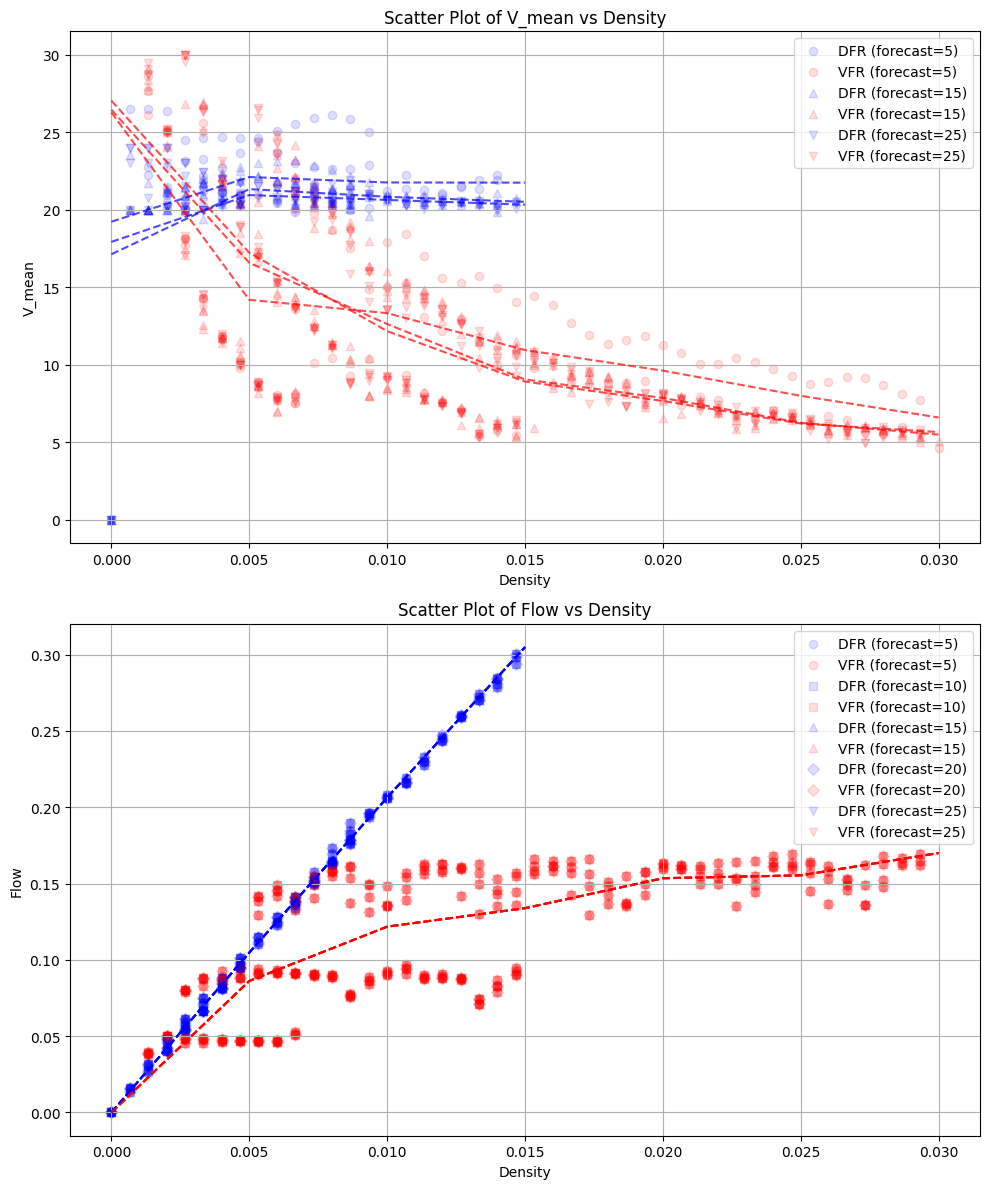

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_result(result_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = result_df[result_df['is_success']]

    # noise_forecast_timeごとにデータを分ける
    noise_forecast_times = sorted(successful_results['noise_forecast_time'].unique())
    
    # マーカーの種類を指定
    markers = ['o', 's', '^', 'D', 'v']
    colors = ['blue', 'red']  # DFRとVFRで色を分ける

    # プロットの準備
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        if noise_forecast_time in [10, 20]:
            continue
        dfr_data = {'density': [], 'v_mean': [], 'flow': []}
        vfr_data = {'density': [], 'v_mean': [], 'flow': []}

        # 各densityに対するv_meanの平均を計算するための辞書
        dfr_density_v_mean = defaultdict(list)
        vfr_density_v_mean = defaultdict(list)

        # noise_forecast_timeごとにフィルタリング
        filtered_results = successful_results[successful_results['noise_forecast_time'] == noise_forecast_time]

        for entry in filtered_results.to_dict(orient='records'):
            if entry['v_mean'] is not None:
                for density, v_mean in entry['v_mean'].items():
                    if entry['type'] == 'dfr':
                        dfr_data['density'].append(density)
                        dfr_data['v_mean'].append(v_mean)
                        dfr_data['flow'].append(density * v_mean)
                        dfr_density_v_mean[density].append(v_mean)
                    elif entry['type'] == 'vfr':
                        vfr_data['density'].append(density)
                        vfr_data['v_mean'].append(v_mean)
                        vfr_data['flow'].append(density * v_mean)
                        vfr_density_v_mean[density].append(v_mean)

        plot_densities = np.arange(0.00, 0.055, 0.005)

        def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
            density_avg_v_mean = {}
            density_avg_flow = {}

            for target_density in plot_densities:
                lower_bound = target_density - 0.0025
                upper_bound = target_density + 0.0025

                # 密度範囲に入るデータをフィルタリング
                v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                                    if lower_bound < density <= upper_bound
                                    for v_mean in v_mean_list]

                if v_means_in_range:
                    avg_v_mean = np.mean(v_means_in_range)
                    density_avg_v_mean[target_density] = avg_v_mean
                    density_avg_flow[target_density] = target_density * avg_v_mean

            return density_avg_v_mean, density_avg_flow

        # DFRとVFRの平均計算
        dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
        vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)

        # ソートしてリスト化
        dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
        vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

        dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
        vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

        # v_mean vs density
        axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color=colors[0], linestyle='--', alpha=0.7)
        axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color=colors[1], linestyle='--', alpha=0.7)

    axs[0].set_xlabel('Density')
    axs[0].set_ylabel('V_mean')
    axs[0].set_title('Scatter Plot of V_mean vs Density')
    axs[0].legend()
    axs[0].grid(True)

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        # flow vs density
        axs[1].scatter(dfr_data['density'], dfr_data['flow'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[1].scatter(vfr_data['density'], vfr_data['flow'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color=colors[0], linestyle='--', alpha=0.7)
        axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color=colors[1], linestyle='--', alpha=0.7)

    axs[1].set_xlabel('Density')
    axs[1].set_ylabel('Flow')
    axs[1].set_title('Scatter Plot of Flow vs Density')
    axs[1].legend()
    axs[1].grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.savefig(f"./images/test_df_combined_totalTime={TOTAL_TIME}.png")
    plt.show()

# 使用例
plot_result(result_df)


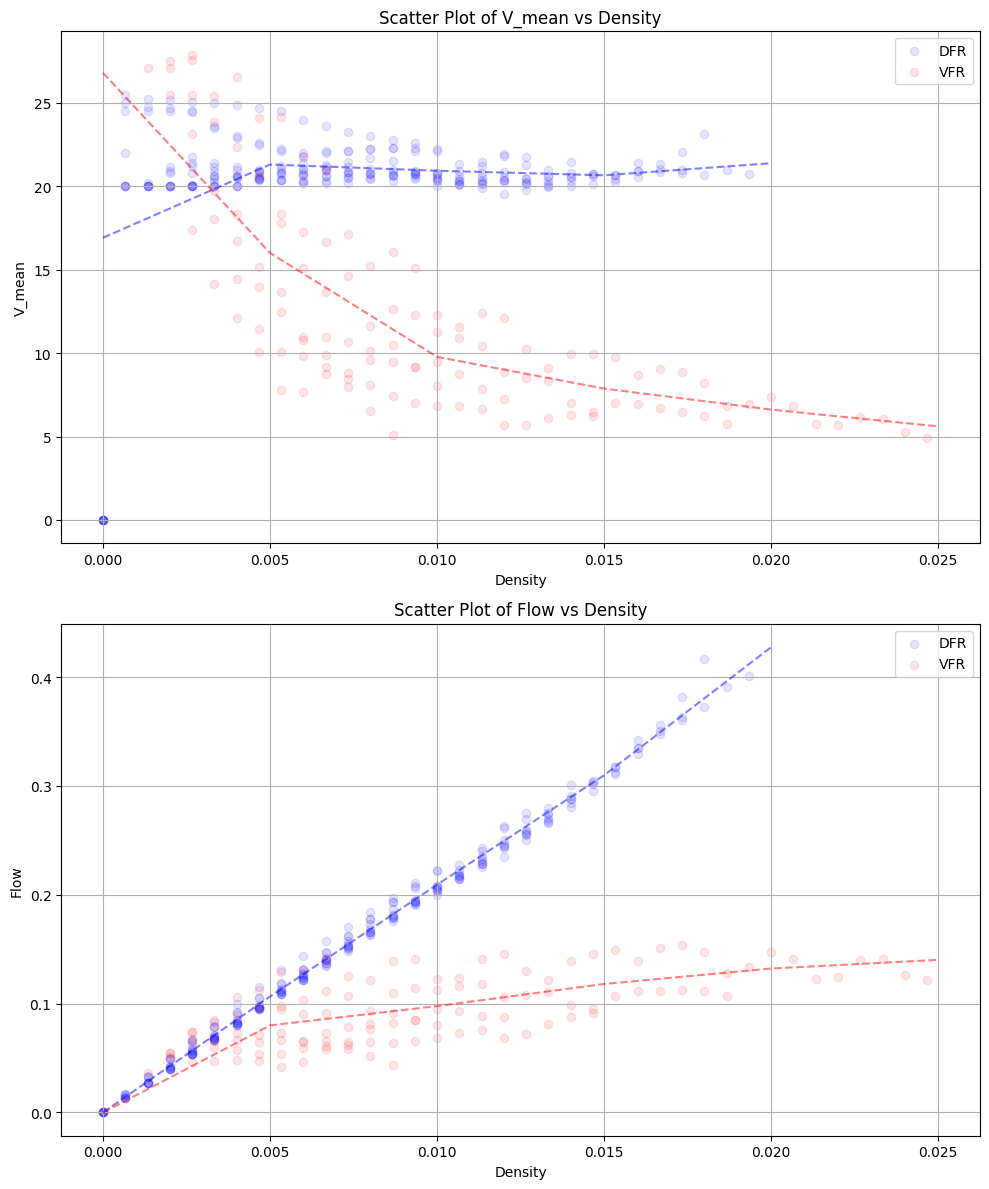

In [19]:
# result_dfではなくresultオブジェクトを使ったもの

dfr_data = {'density': [], 'v_mean': [], 'flow': []}
vfr_data = {'density': [], 'v_mean': [], 'flow': []}

# 各densityに対するv_meanの平均を計算するための辞書
dfr_density_v_mean = defaultdict(list)
vfr_density_v_mean = defaultdict(list)

for entry in results:
    if entry['v_mean'] is not None:
        for density, v_mean in entry['v_mean'].items():
            if entry['type'] == 'dfr':
                dfr_data['density'].append(density)
                dfr_data['v_mean'].append(v_mean)
                dfr_data['flow'].append(density * v_mean)
                dfr_density_v_mean[density].append(v_mean)
            elif entry['type'] == 'vfr':
                vfr_data['density'].append(density)
                vfr_data['v_mean'].append(v_mean)
                vfr_data['flow'].append(density * v_mean)
                vfr_density_v_mean[density].append(v_mean)

plot_densities = np.arange(0.00, 0.055, 0.005)

def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
    density_avg_v_mean = {}
    density_avg_flow = {}

    for target_density in plot_densities:
        lower_bound = target_density - 0.0025
        upper_bound = target_density + 0.0025
        
        # 密度範囲に入るデータをフィルタリング
        v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                            if lower_bound < density <= upper_bound
                            for v_mean in v_mean_list]
        
        if v_means_in_range:
            avg_v_mean = np.mean(v_means_in_range)
            density_avg_v_mean[target_density] = avg_v_mean
            density_avg_flow[target_density] = target_density * avg_v_mean

    return density_avg_v_mean, density_avg_flow


# DFRとVFRの平均計算
dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)


# ソートしてリスト化
dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

# プロット
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# v_mean vs density
axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color='blue', label='DFR', alpha=0.1)
axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color='blue', linestyle='--', alpha=0.5)
axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color='red', linestyle='--', alpha=0.5)

axs[0].set_xlabel('Density')
axs[0].set_ylabel('V_mean')
axs[0].set_title('Scatter Plot of V_mean vs Density')
axs[0].legend()
axs[0].grid(True)

# flow vs density
axs[1].scatter(dfr_data['density'], dfr_data['flow'], color='blue', label='DFR', alpha=0.1)
axs[1].scatter(vfr_data['density'], vfr_data['flow'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color='blue', linestyle='--', alpha=0.5)
axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color='red', linestyle='--', alpha=0.5)


axs[1].set_xlabel('Density')
axs[1].set_ylabel('Flow')
axs[1].set_title('Scatter Plot of Flow vs Density')
axs[1].legend()
axs[1].grid(True)

# グラフを表示
plt.tight_layout()
plt.savefig(f"./images/n_period={NOISE_PERIOD}_n_forecast={NOISE_FORECAST_TIME}_n_freq={NOISE_FREQUENCY}_totalTime={TOTAL_TIME}.png")
plt.show()


In [16]:
vlog = simulation.v_mean_log
print(vlog[300:340])
table = simulation.reservation_table.eta_table
print(table[table["car_idx"] == 0])

[{'time': 33.0, 'v_mean': 20.04736842105263, 'density': 0.019, 'event_flg': None}, {'time': 33.1, 'v_mean': 20.031578947368423, 'density': 0.019, 'event_flg': None}, {'time': 33.2, 'v_mean': 20.01578947368421, 'density': 0.019, 'event_flg': None}, {'time': 33.300000000000004, 'v_mean': 20.0, 'density': 0.019, 'event_flg': None}, {'time': 33.4, 'v_mean': 19.98421052631579, 'density': 0.019, 'event_flg': None}, {'time': 33.5, 'v_mean': 19.968421052631577, 'density': 0.019, 'event_flg': None}, {'time': 33.6, 'v_mean': 19.95263157894737, 'density': 0.019, 'event_flg': None}, {'time': 33.7, 'v_mean': 19.936842105263157, 'density': 0.019, 'event_flg': None}, {'time': 33.800000000000004, 'v_mean': 19.92105263157895, 'density': 0.019, 'event_flg': None}, {'time': 33.9, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.0, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.1, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': N

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 24.933763884510753, 25.00205455537177, 25.045066351248195, 25.078284478181345, 25.107649150798323, 25.13543427568102, 25.162509497197192, 25.189207542893186, 25.21565612084416, 25.241904739377077, 25.26797310634123, 25.29386957926704, 25.319598191088915, 25.34516132271463, 25.37056071867525, 25.39579787278342, 25.420874174509436, 25.44579096457028, 25.470549556103492, 25.49515124281058, 25.51959730216808, 25.54388899677207, 25.568027574976497, 25.592014271262684, 25.615850306503347, 25.639536888187706, 25.66307521062626, 25.686466455148178, 25.709711790291863, 25.73281237199282, 26.032812371992833, 26.332812371992844, 26.632812371992856, 26.932812371992867, 27.23281237199288, 27.5328123719

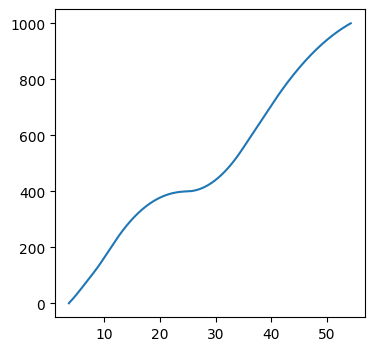

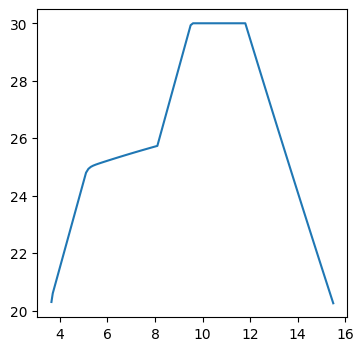

In [15]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])



In [16]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images/dfr')
video_file = f'output_video_TTC={TTC}.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705